# Small Data Mini Classification Project: Life Expectancy
Author: Ishan Porwal

## Introduction


In [111]:
# import necessary modules
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns


# load and read data
df = pd.read_csv('life_expectancy.csv')

# cleaning data and converting categorical values to binary
df = df.drop(["Country", "Hepatitis B", "Measles", "Polio", "Diphtheria", 
              "HIV/AIDS", "infant deaths", "under-five deaths"], axis=1)
df.head()
df = df.dropna()
df = pd.get_dummies(df, columns=["Status"], drop_first=True)

# splitting testing and training data
X = df.drop("Life expectancy", axis=1)
y = df["Life expectancy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# get mean to set threshold
print("Life Expectancy Statistics:")
print(y.describe())

# scaling and converting data to tensors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

Life Expectancy Statistics:
count    2026.000000
mean       68.820089
std         9.910989
min        36.300000
25%        62.700000
50%        71.600000
75%        75.575000
max        89.000000
Name: Life expectancy, dtype: float64


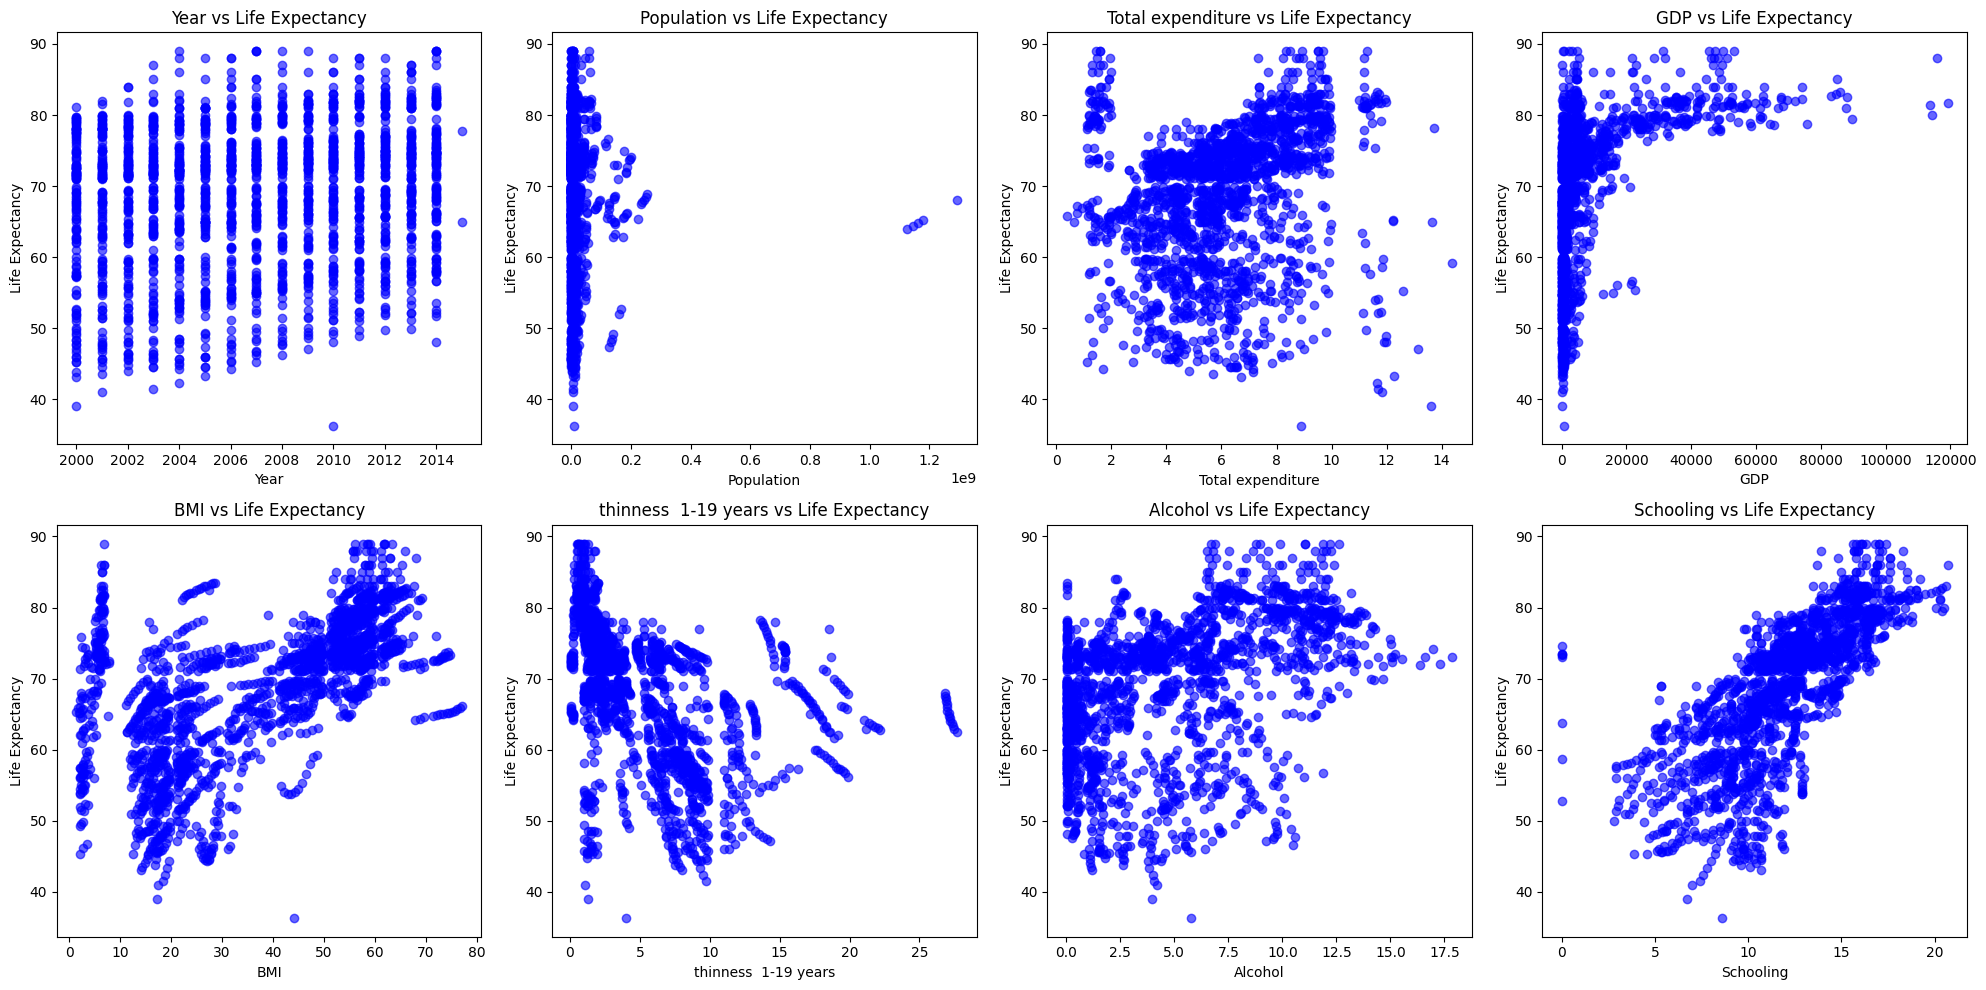

In [112]:
# make subplots relating factors and life expectancy
factors = ['Year', 'Population', 'Total expenditure', 'GDP', 'BMI', 'thinness  1-19 years', 'Alcohol', 'Schooling']

# Create subplots: 4 rows, 4 columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

# Plot each factor
for i, factor in enumerate(factors):
    axes[i].scatter(df[factor], df['Life expectancy'], color='blue', alpha=0.6)
    axes[i].set_title(f'{factor} vs Life Expectancy')
    axes[i].set_xlabel(factor)
    axes[i].set_ylabel('Life Expectancy')

# Hide any unused subplots (if there are any)
for j in range(len(factors), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [113]:
# training function
def train_model(model, criterion, optimizer, num_epochs=1000):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        # forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        # evaluating model
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_losses.append(test_loss.item())
        # printing epoch stats
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    return train_losses, test_losses

# evaluation function
def evaluate_model(model, threshold=68.8):
    model.eval()
    with torch.no_grad():
        # convert model predictions from tensors to numpy arrays
        train_predictions = model(X_train_tensor).numpy()
        test_predictions = model(X_test_tensor).numpy()
    # calculate root mean squared error for training and testing
    train_mse = np.mean((train_predictions - y_train.values.reshape(-1, 1))**2)
    test_mse = np.mean((test_predictions - y_test.values.reshape(-1, 1))**2)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    # binary classification of high/low life expectancy
    train_predictions_class = (train_predictions >= threshold).astype(int)
    test_predictions_class = (test_predictions >= threshold).astype(int)
    y_train_class = (y_train.values >= threshold).astype(int)
    y_test_class = (y_test.values >= threshold).astype(int)
    return test_predictions, y_test_class, test_predictions_class

# function to get classification metrics
def classification_metrics(y_test_class, test_predictions_class):
    # generate and plot confusion matrix
    conf_matrix = confusion_matrix(y_test_class, test_predictions_class)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    # calculate accuracy, precision, and recall
    accuracy = accuracy_score(y_test_class, test_predictions_class)
    precision = precision_score(y_test_class, test_predictions_class)
    recall = recall_score(y_test_class, test_predictions_class)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return accuracy, precision, recall

# function to plot losses
def plot_losses(train_losses, test_losses, nn):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Loss during Training and Testing ({nn})')
    plt.legend()
    plt.yscale('log')
    plt.show()

# function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test, test_predictions, nn):
    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(y_test, test_predictions, c=test_predictions, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Predicted Life Expectancy')  # Add a color bar for reference
    plt.xlabel("Actual Life Expectancy")
    plt.ylabel("Predicted Life Expectancy")
    plt.title(f"Actual vs Predicted Life Expectancy ({nn})")
    plt.grid(True)
    plt.show()

In [114]:
#----------------Defining Neural Network Functions------------------

# simple 3 layer feed forward neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        # applying ReLU activation function
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# deeper 7 layer feed forward neural network
class DeeperNN(nn.Module):
    def __init__(self, input_size):
        super(DeeperNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 1)
    def forward(self, x):
        # applying ReLu activation function
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        return x

Epoch [100/1000], Train Loss: 4302.9346, Test Loss: 4239.7251
Epoch [200/1000], Train Loss: 2431.3601, Test Loss: 2439.1072
Epoch [300/1000], Train Loss: 703.0612, Test Loss: 717.4471
Epoch [400/1000], Train Loss: 287.7042, Test Loss: 281.8426
Epoch [500/1000], Train Loss: 177.8571, Test Loss: 174.6644
Epoch [600/1000], Train Loss: 141.8083, Test Loss: 141.0844
Epoch [700/1000], Train Loss: 122.5510, Test Loss: 123.0682
Epoch [800/1000], Train Loss: 108.7914, Test Loss: 109.9521
Epoch [900/1000], Train Loss: 97.9693, Test Loss: 99.3717
Epoch [1000/1000], Train Loss: 88.8046, Test Loss: 90.3827


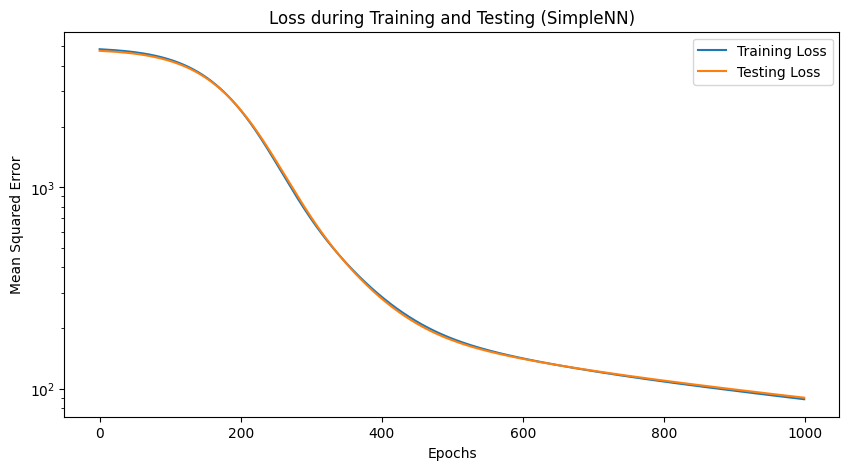

Train RMSE: 9.42
Test RMSE: 9.51


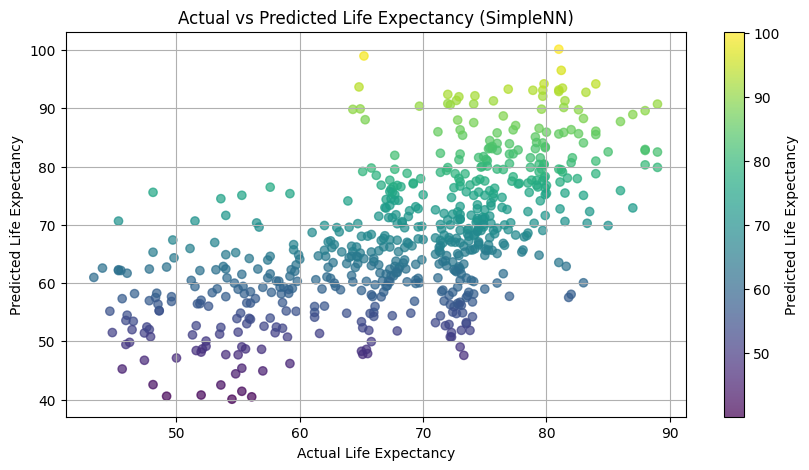

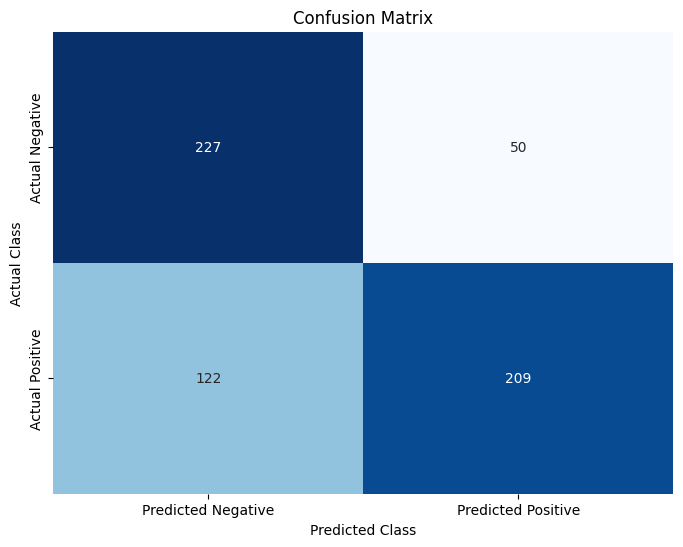

Accuracy: 0.7171
Precision: 0.8069
Recall: 0.6314


(0.7171052631578947,
 np.float64(0.806949806949807),
 np.float64(0.6314199395770392))

In [115]:
#--------------------------- First Model Iteration: Simple 3 Layer-----------------------------

input_size = X_train.shape[1]
model = SimpleNN(input_size)

# initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# train model
train_losses, test_losses = train_model(model, criterion, optimizer, num_epochs=1000)

# plot training and testing losses
plot_losses(train_losses, test_losses, "SimpleNN")

# evaluate model and get predictions
test_predictions, y_test_class, test_predictions_class = evaluate_model(model)

# plot actual vs predicted values
plot_actual_vs_predicted(y_test, test_predictions, "SimpleNN")

# calculate and display classification metrics
classification_metrics(y_test_class, test_predictions_class)

Epoch [100/1000], Train Loss: 401.6200, Test Loss: 361.6647
Epoch [200/1000], Train Loss: 106.5049, Test Loss: 106.1868
Epoch [300/1000], Train Loss: 70.5522, Test Loss: 71.9854
Epoch [400/1000], Train Loss: 47.1116, Test Loss: 48.4184
Epoch [500/1000], Train Loss: 32.2490, Test Loss: 34.1030
Epoch [600/1000], Train Loss: 24.6306, Test Loss: 27.3825
Epoch [700/1000], Train Loss: 20.7472, Test Loss: 24.3342
Epoch [800/1000], Train Loss: 18.4646, Test Loss: 22.8849
Epoch [900/1000], Train Loss: 16.9155, Test Loss: 22.0314
Epoch [1000/1000], Train Loss: 15.7054, Test Loss: 21.3752


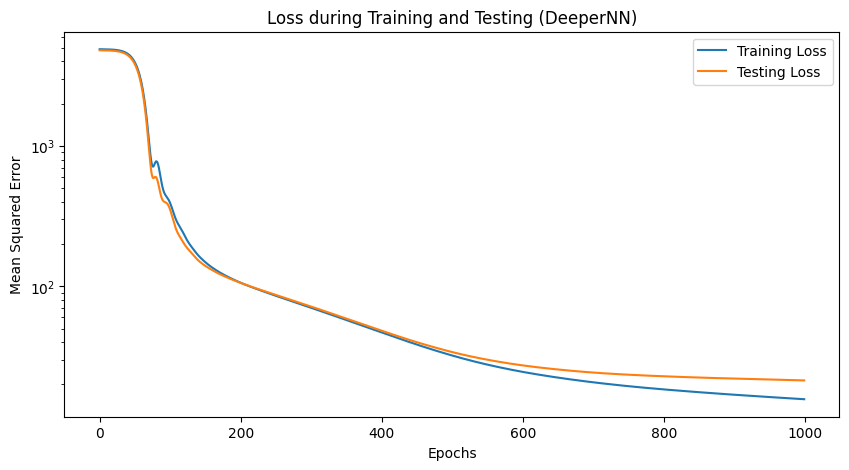

Train RMSE: 3.96
Test RMSE: 4.62


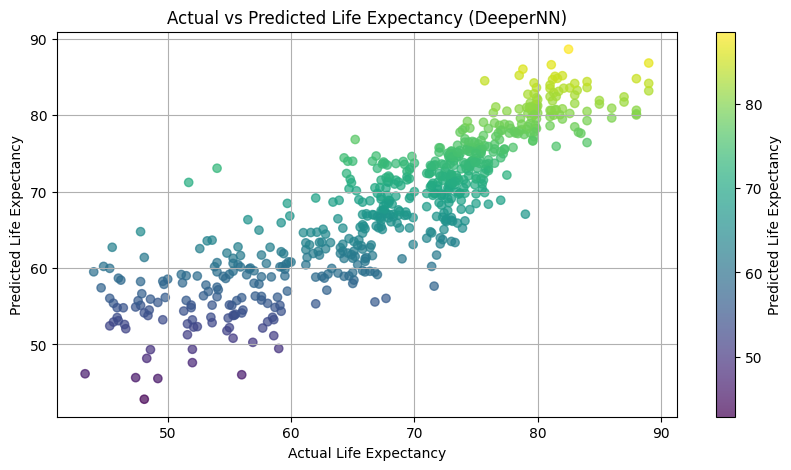

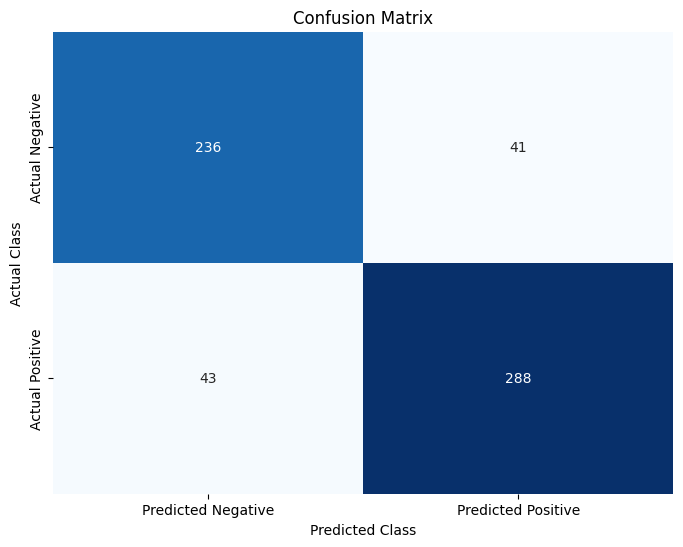

Accuracy: 0.8618
Precision: 0.8754
Recall: 0.8701


(0.8618421052631579,
 np.float64(0.8753799392097265),
 np.float64(0.8700906344410876))

In [116]:
#--------------------------- Second Iteration: Deeper 7 Layer -----------------------------

input_size = X_train.shape[1]
model = DeeperNN(input_size)

# initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# train model
train_losses, test_losses = train_model(model, criterion, optimizer, num_epochs=1000)

# plot training and testing losses
plot_losses(train_losses, test_losses, "DeeperNN")

# evaluate model and get predictions
test_predictions, y_test_class, test_predictions_class = evaluate_model(model)

# plot actual vs predicted values
plot_actual_vs_predicted(y_test, test_predictions, "DeeperNN")

# calculate and display classification metrics
classification_metrics(y_test_class, test_predictions_class)

Epoch [100/1000], Train Loss: 22.0229, Test Loss: 24.7962
Epoch [200/1000], Train Loss: 14.9597, Test Loss: 20.3519
Epoch [300/1000], Train Loss: 24.4880, Test Loss: 26.0634
Epoch [400/1000], Train Loss: 29.5298, Test Loss: 34.2748
Epoch [500/1000], Train Loss: 14.7763, Test Loss: 22.7208
Epoch [600/1000], Train Loss: 9.3114, Test Loss: 18.3702
Epoch [700/1000], Train Loss: 8.5284, Test Loss: 14.9936
Epoch [800/1000], Train Loss: 10.6724, Test Loss: 20.5505
Epoch [900/1000], Train Loss: 6.8669, Test Loss: 17.4777
Epoch [1000/1000], Train Loss: 6.0502, Test Loss: 15.3857


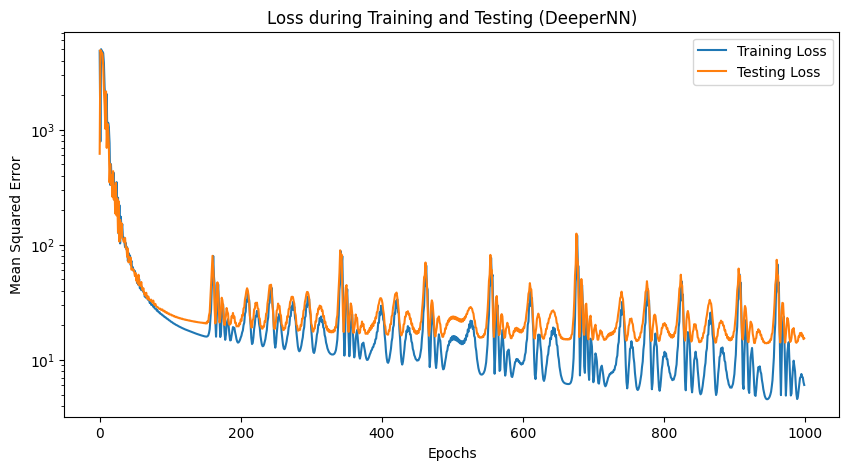

Train RMSE: 2.34
Test RMSE: 3.92


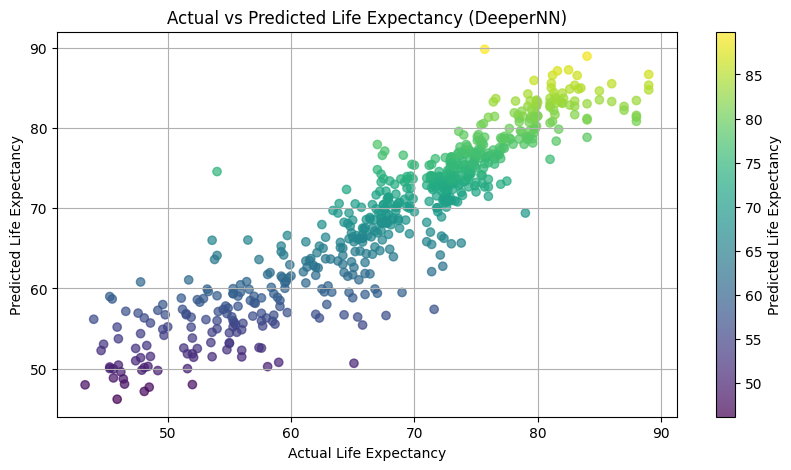

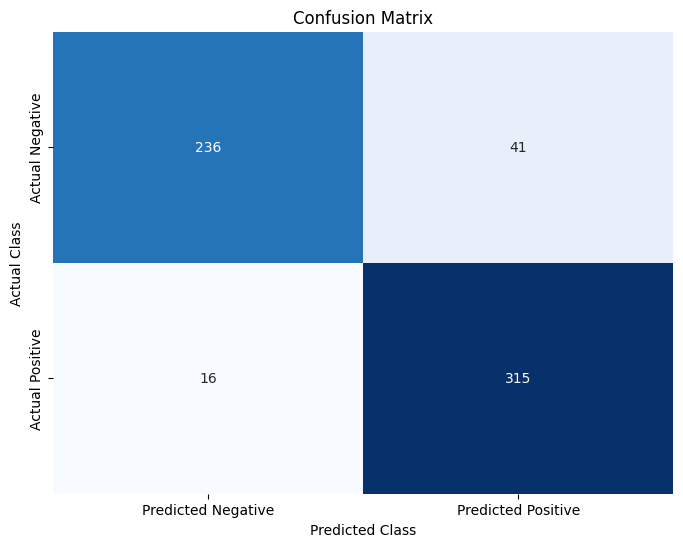

Accuracy: 0.9062
Precision: 0.8848
Recall: 0.9517


(0.90625, np.float64(0.8848314606741573), np.float64(0.9516616314199395))

In [117]:
#--------------------------- Third Model Iteration: Deeper 7 Layer with High Lambda Value -----------------------------

input_size = X_train.shape[1]
model = DeeperNN(input_size)

# initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# train model
train_losses, test_losses = train_model(model, criterion, optimizer, num_epochs=1000)

# plot training and testing losses
plot_losses(train_losses, test_losses, "DeeperNN")

# evaluate model and get predictions
test_predictions, y_test_class, test_predictions_class = evaluate_model(model)

# plot actual vs predicted values
plot_actual_vs_predicted(y_test, test_predictions, "DeeperNN")

# calculate and display classification metrics
classification_metrics(y_test_class, test_predictions_class)